## K-means 군집 분석을 사용하여 프로야구 타자 기록 데이터를 분류

⚾ 사용된 타격 지표 (세이버메트릭스)

- OPS (On-base Plus Slugging): 출루율 + 장타율, 타자의 공격력을 측정하는 대표적인 지표

- ISO (Isolated Power, 순수 장타율): 장타율 - 타율, 타자의 순수한 장타 생산 능력을 나타냄

- SECA (Secondary Average, 2차 타율): 안타 외의 요소(볼넷, 장타, 도루 등)를 통해 얼마나 많은 루타를 얻었는지 측정

- TA (Total Average, 총 공격력): 타자의 종합적인 공격 생산성을 나타내는 지표

- RC (Runs Created, 득점 생산): 타자가 팀의 득점에 얼마나 공헌했는지 추정하는 지표

- RC/27 (Runs Created per 27 Outs): 해당 타자로만 9명이 구성된 팀이 한 경기(27아웃)를 치렀을 때 얻을 수 있는 예상 득점

- wOBA (weighted On-Base Average, 가중 출루율): 타자가 타석당 공격에 얼마나 총체적으로 기여했는지 나타냄,  
    출루율 스케일의 값을 가짐, 현재 가장 정확도가 높은 타격 지표 중 하나로 평가됨

- XR (Extrapolated Runs, 추정 득점력): RC와 유사하게 팀 득점에 대한 공헌도를 추정하는 선형 공식 기반 지표

### 환경 설정

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"     # K-means 알고리즘의 병렬 처리 시 발생하는 오류를 방지

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True,  # 지수 표기법 억제 (예: 1e-10 대신 0.0000000001로 표시)
                    precision=8)    # 소수점 이하 자리수를 8자리로 표현

### 데이터 준비

In [3]:
hitter1 = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/2000_2001_hitter.csv')
hitter2 = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/2002_2013_hitter.csv')
hitter3 = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/2014_hitter.csv')

# 데이터프레임 병합 
df = pd.concat([hitter1, hitter2, hitter3], 
                          ignore_index=True) # 기존 인덱스 무시
df.head()

,YrPlayer,Year,Rank,Player,Team,AVG,G,PA,AB,H,...,TA,RC,RC/27,wOBA,XR,R,SAC,MH,RISP,PH-BA
0,2000박종호,2000,1,박종호,현대,0.340,121,541,441,150,...,0.976667,100.354529,8.286154,0.400138,92.804,NaN,NaN,NaN,NaN,NaN
1,2000김동주,2000,2,김동주,두산,0.339,127,539,469,159,...,1.063830,115.473840,9.306847,0.431993,105.000,NaN,NaN,NaN,NaN,NaN
2,2000브리또,2000,3,브리또,SK,0.338,103,452,405,137,...,0.931655,86.204956,8.224501,0.400969,77.820,NaN,NaN,NaN,NaN,NaN
3,2000송지만,2000,4,송지만,한화,0.338,120,530,468,158,...,1.110092,119.916981,9.811389,0.436688,107.594,NaN,NaN,NaN,NaN,NaN
4,2000데이비스,2000,5,데이비스,한화,0.334,107,458,419,140,...,0.923588,82.605677,7.125729,0.394586,80.284,NaN,NaN,NaN,NaN,NaN


### 데이터 전처리

In [4]:
# -------------
# 변수 선택
# -------------
X = df[['OPS','ISO','SECA','TA','RC','RC/27','wOBA','XR']].copy()   # 군집 분석에 사용할 8개의 타격 지표 선택
X.head()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR
0,0.917819,0.149660,0.297052,0.976667,100.354529,8.286154,0.400138,92.804
1,1.017141,0.264392,0.379531,1.063830,115.473840,9.306847,0.431993,105.000
2,0.931997,0.195062,0.274074,0.931655,86.204956,8.224501,0.400969,77.820
3,1.031229,0.284188,0.423077,1.110092,119.916981,9.811389,0.436688,107.594
4,0.932665,0.231504,0.324582,0.923588,82.605677,7.125729,0.394586,80.284


<Axes: >

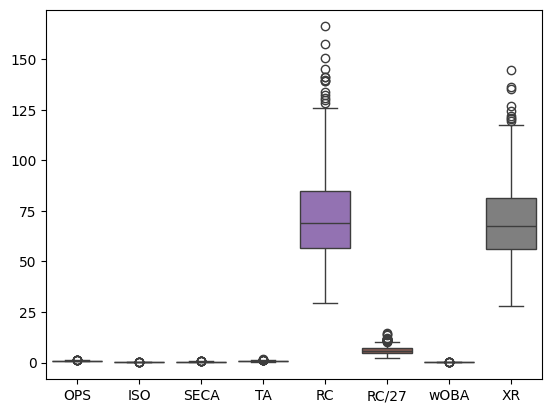

In [5]:
# -------------
# 데이터 분포 확인
# -------------
sns.boxplot(X)    

- 스케일링 전, 원본 데이터의 분포 확인 (이상치 포함)

In [6]:
# -------------
# 데이터 스케일링
# -------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR
0,0.976149,-0.074229,0.104176,1.108646,1.248725,1.204841,1.118807,1.214334
1,1.897116,1.679891,1.054165,1.654227,1.929967,1.758231,1.894866,1.857449
2,1.107616,0.619910,-0.160485,0.826902,0.611178,1.171415,1.139040,0.424202
3,2.027750,1.982543,1.555727,1.943794,2.130165,2.031780,2.009248,1.994235
4,1.113814,1.177062,0.421269,0.776410,0.449003,0.575692,0.983538,0.554133
...,...,...,...,...,...,...,...,...
644,0.412201,1.132233,1.026659,0.530672,-0.349031,0.204838,0.367294,-0.332603
645,-0.737598,-0.063556,-0.128516,-0.769272,-0.883686,-1.044144,-0.834318,-0.745176
646,-0.422330,-0.051699,0.773504,0.116640,-0.382668,-0.325418,-0.435385,-0.335978
647,-1.460858,-1.396013,-1.627267,-1.628601,-1.069759,-1.378851,-1.472888,-1.119570


StandardScaler를 사용하여 X의 데이터를 **표준화(Standard Scaling)**
- (각 변수의 평균을 0, 표준편차를 1로 맞춤. 군집 분석 전 필수적인 작업)

In [7]:
# -------------
# 데이터의 기술통계량 
# -------------
X_scaled.describe()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR
count,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02,6.490000e+02
mean,-1.012715e-16,-2.737068e-17,-1.642241e-16,3.174998e-16,1.806465e-16,-2.175969e-16,-1.231680e-15,1.696982e-16
std,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00,1.000771e+00
min,-2.221209e+00,-2.099251e+00,-2.174985e+00,-2.009087e+00,-1.949528e+00,-2.004141e+00,-2.325215e+00,-2.193504e+00
25%,-7.375979e-01,-7.734432e-01,-7.718542e-01,-7.457017e-01,-7.151492e-01,-6.870222e-01,-7.029325e-01,-7.094234e-01
50%,-6.997280e-02,-6.355581e-02,-1.276698e-01,-1.011109e-01,-1.746972e-01,-1.614607e-01,-4.306436e-02,-1.321170e-01
75%,5.791071e-01,6.334287e-01,6.420412e-01,5.614827e-01,5.425493e-01,5.014907e-01,6.150322e-01,6.076030e-01
max,3.574147e+00,3.734017e+00,4.905380e+00,4.583059e+00,4.212650e+00,4.696391e+00,3.503572e+00,3.953323e+00


In [8]:
# 지수 형식을 정수 형식으로 출력
pd.set_option('display.float_format', '{:.4f}'.format)
X_scaled.describe()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR
count,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000,649.0000
mean,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000
std,1.0008,1.0008,1.0008,1.0008,1.0008,1.0008,1.0008,1.0008
min,-2.2212,-2.0993,-2.1750,-2.0091,-1.9495,-2.0041,-2.3252,-2.1935
25%,-0.7376,-0.7734,-0.7719,-0.7457,-0.7151,-0.6870,-0.7029,-0.7094
50%,-0.0700,-0.0636,-0.1277,-0.1011,-0.1747,-0.1615,-0.0431,-0.1321
75%,0.5791,0.6334,0.6420,0.5615,0.5425,0.5015,0.6150,0.6076
max,3.5741,3.7340,4.9054,4.5831,4.2126,4.6964,3.5036,3.9533


- 스케일링이 정상적으로 적용 되었는지 검토 (평균이 0에 가깝고, 표준편차가 1에 가까운 지 확인)

<Axes: >

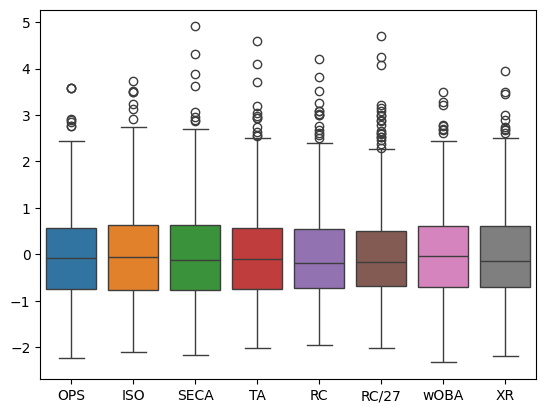

In [9]:
# -------------
# 데이터 분포 확인
# -------------
sns.boxplot(X_scaled)

- 스케일링 후의 데이터 분포 확인 (이상치 자체는 존재하지만, 변수 간 스케일은 통일)

### 군집화

#### 최적의 k 찾기 (K-means 파라미터 결정)

In [10]:
# -------------
# 엘보우 기법으로 최적의 k 찾기
# -------------
from sklearn.cluster import KMeans
inertia = []
for n in range(2,7):
    km = KMeans(n_clusters=n)
    km.fit(X_scaled)
    print(km.inertia_)
    inertia.append(km.inertia_)

2225.953572555236
1334.9614684794237
1023.2731074927711
866.5429996546828
772.5256007649205


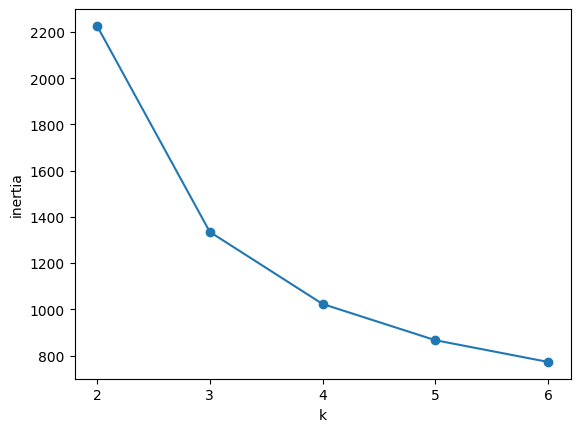

In [11]:
# -------------
# 계산된 inertia 값을 그래프로 시각화
# -------------
plt.plot(range(2,7), inertia, marker='o')
plt.xticks(range(2,7))
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

In [12]:
# ------------------
# 실루엣 계수로 최적의 k값 찾기
# ------------------
from sklearn.metrics import silhouette_score
for k in range(2,7):
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    score = silhouette_score(X_scaled, km.labels_)
    print(f'k:{k} ==> {score}')

k:2 ==> 0.47657112956203473
k:3 ==> 0.4273993507604855
k:4 ==> 0.35303266098546354
k:5 ==> 0.32438532886466814
k:6 ==> 0.301086845839397


- k를 2부터 6까지 변화시키며 평균 실루엣 계수를 계산하고 출력

    - 군집 내 응집도와 군집 간 분리도를 동시에 측정하며, 1에 가까울 수록 좋음

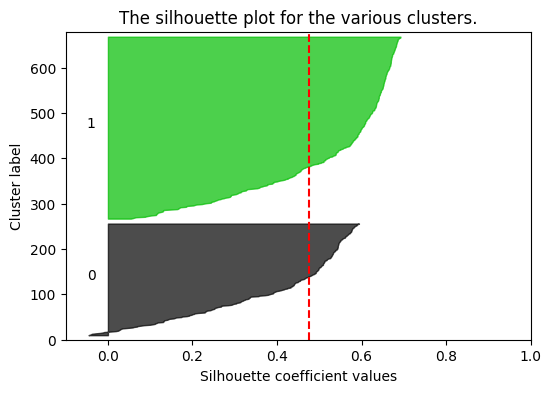

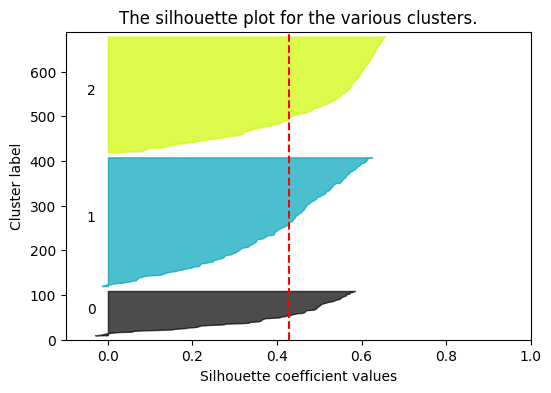

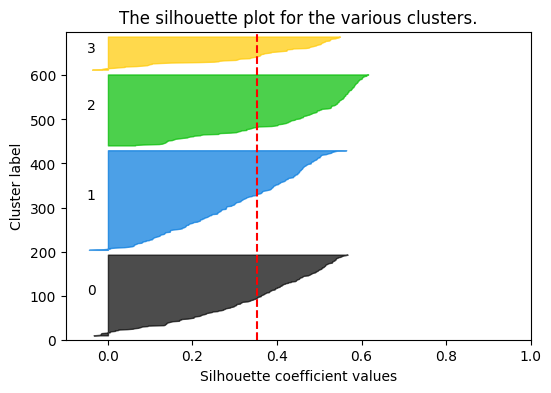

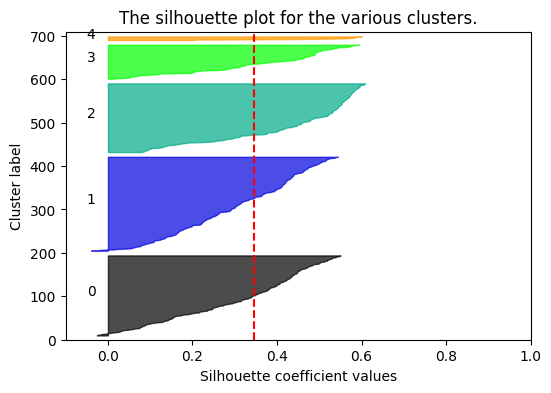

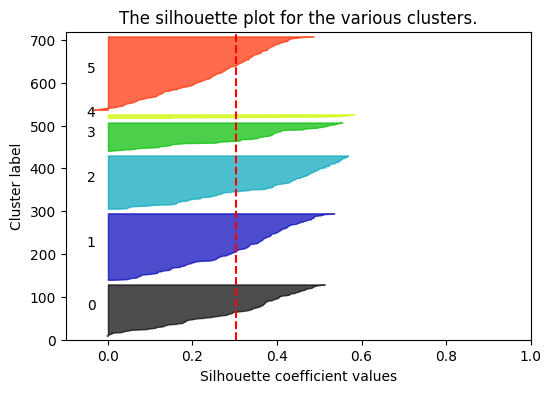

In [13]:
# ------------------
# 실루엣 플롯(그래프)로 찾기
# ------------------
from silhouette_analysis import silhouette_plot
for k in range(2,7):
    silhouette_plot(X_scaled, k)

- 엘보우 및 실루엣 분석 결과를 바탕으로 최적의 군집 개수 k를 3으로 결정

#### 군집화

In [14]:
# -----------------------
# k-means clustering
# -----------------------
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(X_scaled)
cluster = km.labels_

- $k$를 3으로 결정하고, K-means 모델을 학습시킨 후 **군집 레이블(cluster)**을 생성

### 군집화 결과 분석

In [15]:
# -----------------------
# 군집 라벨을 데이터프레임의 컬럼으로 추가
# -----------------------
X['cluster'] = cluster
X.head()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster
0,0.9178,0.1497,0.2971,0.9767,100.3545,8.2862,0.4001,92.8040,1
1,1.0171,0.2644,0.3795,1.0638,115.4738,9.3068,0.4320,105.0000,0
2,0.9320,0.1951,0.2741,0.9317,86.2050,8.2245,0.4010,77.8200,1
3,1.0312,0.2842,0.4231,1.1101,119.9170,9.8114,0.4367,107.5940,0
4,0.9327,0.2315,0.3246,0.9236,82.6057,7.1257,0.3946,80.2840,1


In [16]:
# cols 변수 정의: 군집 분석에 사용된 8개의 타격 지표
cols = ['OPS', 'ISO', 'SECA', 'TA', 'RC', 'RC/27', 'wOBA', 'XR']

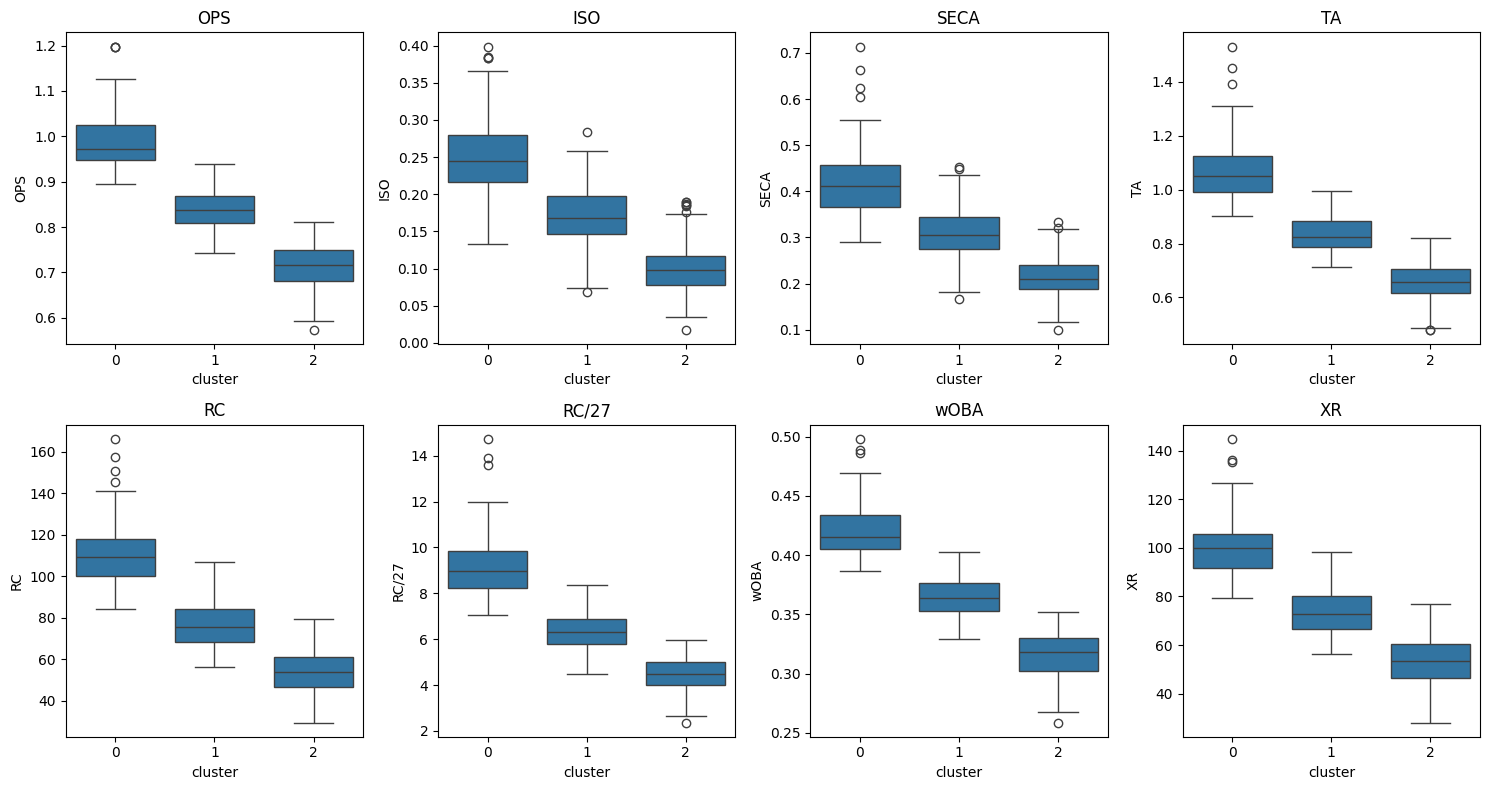

In [17]:
# ---------------------------
# 군집의 특성 분석
#   - 군집별 데이터 분포 확인
# ---------------------------
plt.figure(figsize=(15,8))
for i, col in enumerate(cols):
    plt.subplot(2,4,i+1)
    sns.boxplot(x='cluster', y=col, data=X)
    plt.title(col)
plt.tight_layout()

- 모든 지표(OPS, ISO, SECA, TA, RC, RC/27, wOBA, XR)는 공격 생산성을 나타내며, 값이 높을수록 뛰어난 타자임

 ⚾ **군집별 타자 유형 및 특징 요약**

| 군집 | 타자 유형 (공격 생산성) | 주요 특징 |
|---|---|---|
| **Cluster 0** | **엘리트 타자** | 모든 공격 지표(OPS, wOBA, RC 등)에서 **최고 수준**의 성적 (High Power & Production) |
| **Cluster 1** | **준수한 주전 타자** | 모든 지표에서 **평균적이거나 평균을 상회**하는 성적 (Solid, Average Production) |
| **Cluster 2** | **평균 이하 타자** | 모든 공격 지표에서 **가장 낮은 수준**의 성적 (Low Production & Power) |

In [18]:
# ---------------------------
# 선수별 군집 확인
#   - 데이터프레임에 선수 이름 추가
# ---------------------------
X['YrPlayer'] = df['YrPlayer'].copy()
X.head()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,YrPlayer
0,0.9178,0.1497,0.2971,0.9767,100.3545,8.2862,0.4001,92.8040,1,2000박종호
1,1.0171,0.2644,0.3795,1.0638,115.4738,9.3068,0.4320,105.0000,0,2000김동주
2,0.9320,0.1951,0.2741,0.9317,86.2050,8.2245,0.4010,77.8200,1,2000브리또
3,1.0312,0.2842,0.4231,1.1101,119.9170,9.8114,0.4367,107.5940,0,2000송지만
4,0.9327,0.2315,0.3246,0.9236,82.6057,7.1257,0.3946,80.2840,1,2000데이비스


In [19]:
# ---------------------------
# 잘못 군집화 된 데이터
#   각 데이터 포인트의 실루엣 계수를 계산하여 silhouette 컬럼에 추가
# ---------------------------
from sklearn.metrics import silhouette_samples
X['silhouette'] = silhouette_samples(X_scaled, km.labels_)
X.head()

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,YrPlayer,silhouette
0,0.9178,0.1497,0.2971,0.9767,100.3545,8.2862,0.4001,92.8040,1,2000박종호,0.0820
1,1.0171,0.2644,0.3795,1.0638,115.4738,9.3068,0.4320,105.0000,0,2000김동주,0.5633
2,0.9320,0.1951,0.2741,0.9317,86.2050,8.2245,0.4010,77.8200,1,2000브리또,0.2927
3,1.0312,0.2842,0.4231,1.1101,119.9170,9.8114,0.4367,107.5940,0,2000송지만,0.5844
4,0.9327,0.2315,0.3246,0.9236,82.6057,7.1257,0.3946,80.2840,1,2000데이비스,0.3067


In [20]:
# ---------------------------
# 잘못 군집화 된 데이터
#   개별 실루엣 계수가 0보다 작은 데이터 출력 (잘못 군집화된(다른 군집에 더 가까운) 선수들)
# ---------------------------
X.loc[X['silhouette']<0]

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,YrPlayer,silhouette
73,0.7892,0.1525,0.2506,0.7483,60.7503,5.5602,0.3428,59.5660,1,2001신동주,-0.0137
117,0.7810,0.1597,0.2639,0.7212,63.7204,5.1510,0.3392,63.0480,1,2002박재홍,-0.0147
170,0.9430,0.1634,0.3317,0.9858,92.0677,8.6015,0.4086,84.2580,0,2004이진영,-0.0302
252,0.7710,0.1421,0.3173,0.7516,59.1476,5.1185,0.3398,59.0080,1,2005양준혁,-0.0060
390,0.9110,0.1960,0.3875,0.9665,95.1664,7.6701,0.3952,88.6120,0,2009강봉규,-0.0042
475,0.9280,0.2159,0.3548,0.9897,89.9411,7.8336,0.3999,84.9740,0,2011최정,-0.0086
546,0.8390,0.1070,0.1658,0.7578,63.1457,6.5828,0.3641,58.3300,1,2013이병규,-0.0073
552,0.9400,0.1970,0.3384,0.9860,89.0126,8.3740,0.4094,81.7360,0,2013박석민,-0.0142
623,0.9150,0.2490,0.3360,0.9030,99.6772,7.4140,0.3894,93.5140,0,2014이승엽,-0.0184


In [21]:
# ---------------------------
# 군집의 중심에 있는 선수
#   군집별 실루엣 계수 최대인 데이터
# ---------------------------
idx = X.groupby(by='cluster')['silhouette'].idxmax()
X.loc[idx]

,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,YrPlayer,silhouette
3,1.0312,0.2842,0.4231,1.1101,119.9170,9.8114,0.4367,107.5940,0,2000송지만,0.5844
224,0.8640,0.1891,0.3134,0.8805,75.8439,6.8718,0.3709,72.5200,1,2005클리어,0.6250
84,0.6965,0.0985,0.2071,0.6090,48.2276,4.0439,0.3126,47.8580,2,2001채종범,0.6557


In [22]:
# ---------------------------
# 군집 별 평균 데이터
# ---------------------------
pd.set_option('display.width', 1000)    # 최대 컬럼 표시 일시적으로 늘림

# 평균 계산
cluster_means = X.groupby('cluster').mean(numeric_only=True)

# 결과 출력
print("Cluster Mean Values:")
print(cluster_means)

pd.reset_option('display.width')    # 컬럼 설정 원래 방식으로 되돌림

Cluster Mean Values:
           OPS    ISO   SECA     TA       RC  RC/27   wOBA       XR  silhouette
cluster                                                                        
0       0.9912 0.2501 0.4212 1.0713 110.4799 9.2608 0.4213 100.8849      0.3834
1       0.8409 0.1707 0.3075 0.8351  76.4404 6.3904 0.3653  73.6961      0.3915
2       0.7123 0.0998 0.2151 0.6556  53.8634 4.4714 0.3160  53.4523      0.4842
